# Project: European Soccer Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this report we will invistigate **European Football Database** that includes tables about leagues, matches and players. 

### Questions to be answered in this report:

1. What teams have the highest number of wins each year?
2. What teams have the highest number of wins between 2007-2015?
3. Is Correlation between winning and:
    * defence line class.
    * chance creation from crossing class.
    * defence aggression class.
    * buildup play positioning class.
4. Which players **gained**, **lost** the highest number of rating points between 2007-2016?
5. Does *heading accuracy* rating depend on:
    * height rating.
    * jumping rating.
    * volleys rating.
    * balance rating.
6. Does *longshots* rating depend on:
    * aggression rating.
    * weight rating.
    * shot power rating.
    * strength rating.
7. Does *dribbling* rating depend on:
    * agility rating.
    * acceleration rating.
    * reactions rating.
    * balance rating.
8. Does *sprint speed* rating depend on:
    * acceleration rating.
    * stamina rating.
    * height rating.
    * weight rating.
9. Comparison between Lionel Messi and Cristiano ronaldo overall rating trend between 2007-2015.


In [116]:
import sqlite3
from sqlalchemy import create_engine
import pandas as pd
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
%matplotlib inline 

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In the next cell I'm using `sqlalchemy` to create an engine and read from our SQL database.

In [117]:
engine = sqlalchemy.create_engine('sqlite:///database.sqlite')
df = pd.read_sql("select * from Country", engine)
pd.options.mode.chained_assignment = None

Now that I connected to the database let's load its tables into dataframes.

**notice**: I knew DB schema after exploring the database with SQLite browser

In [118]:
df_league = pd.read_sql("select * from League", engine)
df_country = pd.read_sql("select * from Country", engine)
df_player = pd.read_sql("select * from Player", engine)
df_player_atts = pd.read_sql("select * from Player_Attributes", engine)
df_team_atts = pd.read_sql("select * from Team_Attributes", engine)
df_team = pd.read_sql("select * from Team", engine)
df_match = pd.read_sql("select * from Match", engine)

### Data Cleaning 

In [119]:
df_league.head(2)

id  country_id                    name
0     1           1  Belgium Jupiler League
1  1729        1729  England Premier League

In [120]:
df_country.head(2)

id     name
0     1  Belgium
1  1729  England

As you see there is no use for the country table itself 

so I'll join country table with league table

In [121]:
df_leagues = pd.merge(df_country, df_league, left_on="id", right_on="country_id", how="inner")

In [122]:
df_leagues.head()

id_x   name_x   id_y  country_id                  name_y
0      1  Belgium      1           1  Belgium Jupiler League
1   1729  England   1729        1729  England Premier League
2   4769   France   4769        4769          France Ligue 1
3   7809  Germany   7809        7809   Germany 1. Bundesliga
4  10257    Italy  10257       10257           Italy Serie A

Since the id column is repeated with same values I'll remove the extra columns and rename the one to keep

In [123]:
df_leagues.drop(columns=["id_y", "country_id"], inplace=True)
df_leagues.rename(columns={"id_x": "id", "name_x": "country", "name_y": "league"}, inplace=True)
df_leagues.head()

id  country                  league
0      1  Belgium  Belgium Jupiler League
1   1729  England  England Premier League
2   4769   France          France Ligue 1
3   7809  Germany   Germany 1. Bundesliga
4  10257    Italy           Italy Serie A

Now let's explore *team* and *team attributes* dataframes

In [124]:
df_team.head()

id  team_api_id  team_fifa_api_id     team_long_name team_short_name
0   1         9987             673.0           KRC Genk             GEN
1   2         9993             675.0       Beerschot AC             BAC
2   3        10000           15005.0   SV Zulte-Waregem             ZUL
3   4         9994            2007.0   Sporting Lokeren             LOK
4   5         9984            1750.0  KSV Cercle Brugge             CEB

In [125]:
df_team_atts.head()

id  team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
0   1               434         9930  2010-02-22 00:00:00                60   
1   2               434         9930  2014-09-19 00:00:00                52   
2   3               434         9930  2015-09-10 00:00:00                47   
3   4                77         8485  2010-02-22 00:00:00                70   
4   5                77         8485  2011-02-22 00:00:00                47   

  buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
0              Balanced                   NaN                    Little   
1              Balanced                  48.0                    Normal   
2              Balanced                  41.0                    Normal   
3                  Fast                   NaN                    Little   
4              Balanced                   NaN                    Little   

   buildUpPlayPassing buildUpPlayPassingClass  ... chanceCreationShooting  \
0                  50                   Mixed  ...                     55   
1                  56                   Mixed  ...                     64   
2                  54                   Mixed  ...                     64   
3                  70                    Long  ...                     70   
4                  52                   Mixed  ...                     52   

   chanceCreationShootingClass chanceCreationPositioningClass  \
0                       Normal                      Organised   
1                       Normal                      Organised   
2                       Normal                      Organised   
3                         Lots                      Organised   
4                       Normal                      Organised   

   defencePressure defencePressureClass  defenceAggression  \
0               50               Medium                 55   
1               47               Medium                 44   
2               47               Medium                 44   
3               60               Medium                 70   
4               47               Medium                 47   

  defenceAggressionClass defenceTeamWidth  defenceTeamWidthClass  \
0                  Press               45                 Normal   
1                  Press               54                 Normal   
2                  Press               54                 Normal   
3                 Double               70                   Wide   
4                  Press               52                 Normal   

  defenceDefenderLineClass  
0                    Cover  
1                    Cover  
2                    Cover  
3                    Cover  
4                    Cover  

[5 rows x 25 columns]

In [126]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


In [127]:
df_team_atts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

As you've just seen *team attributes* dataframe has no name column so I'll merge *team* and *team attributes* dataframes   

In [128]:
df_teams = pd.merge(df_team, df_team_atts, left_on="team_api_id", right_on="team_api_id", how="inner")
df_teams.rename(columns = lambda x: x.lower(), inplace=True)
df_teams.head()

id_x  team_api_id  team_fifa_api_id_x team_long_name team_short_name  id_y  \
0     1         9987               673.0       KRC Genk             GEN   485   
1     1         9987               673.0       KRC Genk             GEN   486   
2     1         9987               673.0       KRC Genk             GEN   487   
3     1         9987               673.0       KRC Genk             GEN   488   
4     1         9987               673.0       KRC Genk             GEN   489   

   team_fifa_api_id_y                 date  buildupplayspeed  \
0                 673  2010-02-22 00:00:00                45   
1                 673  2011-02-22 00:00:00                66   
2                 673  2012-02-22 00:00:00                53   
3                 673  2013-09-20 00:00:00                58   
4                 673  2014-09-19 00:00:00                58   

  buildupplayspeedclass  ...  chancecreationshooting  \
0              Balanced  ...                      60   
1              Balanced  ...                      51   
2              Balanced  ...                      56   
3              Balanced  ...                      56   
4              Balanced  ...                      56   

  chancecreationshootingclass  chancecreationpositioningclass defencepressure  \
0                      Normal                       Organised              70   
1                      Normal                       Organised              48   
2                      Normal                       Organised              47   
3                      Normal                       Organised              47   
4                      Normal                       Organised              47   

  defencepressureclass  defenceaggression defenceaggressionclass  \
0                 High                 65                  Press   
1               Medium                 47                  Press   
2               Medium                 45                  Press   
3               Medium                 45                  Press   
4               Medium                 45                  Press   

   defenceteamwidth defenceteamwidthclass  defencedefenderlineclass  
0                70                  Wide                     Cover  
1                54                Normal              Offside Trap  
2                55                Normal                     Cover  
3                55                Normal                     Cover  
4                55                Normal                     Cover  

[5 rows x 29 columns]

In [129]:
df_teams.columns

Index(['id_x', 'team_api_id', 'team_fifa_api_id_x', 'team_long_name',
       'team_short_name', 'id_y', 'team_fifa_api_id_y', 'date',
       'buildupplayspeed', 'buildupplayspeedclass', 'buildupplaydribbling',
       'buildupplaydribblingclass', 'buildupplaypassing',
       'buildupplaypassingclass', 'buildupplaypositioningclass',
       'chancecreationpassing', 'chancecreationpassingclass',
       'chancecreationcrossing', 'chancecreationcrossingclass',
       'chancecreationshooting', 'chancecreationshootingclass',
       'chancecreationpositioningclass', 'defencepressure',
       'defencepressureclass', 'defenceaggression', 'defenceaggressionclass',
       'defenceteamwidth', 'defenceteamwidthclass',
       'defencedefenderlineclass'],
      dtype='object')

Merging resulted in duplicated columns so I'll drop these columns 

And in this analysis I'll depend on attribute class not rating so I'll drop ratings columns

Finally I'll rename the *id* column

In [130]:
df_teams.drop(columns= ['team_fifa_api_id_x', 'team_short_name', 'id_y', 'team_fifa_api_id_y', 'buildupplayspeed', 'buildupplaydribbling', 'buildupplaypassing', 'chancecreationpassing', 'chancecreationcrossing', 'chancecreationshooting', 'defencepressure', 'defenceaggression', 'defenceteamwidth'], inplace=True)

In [131]:
df_teams.rename(columns={ "id_x": "id"}, inplace=True)

In [132]:
df_teams.info()
df_teams.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1457
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              1458 non-null   int64 
 1   team_api_id                     1458 non-null   int64 
 2   team_long_name                  1458 non-null   object
 3   date                            1458 non-null   object
 4   buildupplayspeedclass           1458 non-null   object
 5   buildupplaydribblingclass       1458 non-null   object
 6   buildupplaypassingclass         1458 non-null   object
 7   buildupplaypositioningclass     1458 non-null   object
 8   chancecreationpassingclass      1458 non-null   object
 9   chancecreationcrossingclass     1458 non-null   object
 10  chancecreationshootingclass     1458 non-null   object
 11  chancecreationpositioningclass  1458 non-null   object
 12  defencepressureclass            1458 non-null   

(1458, 16)

Here we notice that the *date* column dtype is object so I'll convert it into datetime.

In [133]:
df_teams["date"] = pd.to_datetime(df_teams["date"])

Now let's explore *player* and *player attributes* dataframes

In [134]:
df_player.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154

In [135]:
df_player_atts.head()

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   ...  vision  penalties  marking  standing_tackle  sliding_tackle  \
0  ...    54.0       48.0     65.0             69.0            69.0   
1  ...    54.0       48.0     65.0             69.0            69.0   
2  ...    54.0       48.0     65.0             66.0            69.0   
3  ...    53.0       47.0     62.0             63.0            66.0   
4  ...    53.0       47.0     62.0             63.0            66.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0  
2        6.0         11.0        10.0             8.0          8.0  
3        5.0         10.0         9.0             7.0          7.0  
4        5.0         10.0         9.0             7.0          7.0  

[5 rows x 42 columns]

In [136]:
df_player.info(), df_player_atts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date            

(None, None)

Again as I did with *teams* dataframes I'll merge *players* dataframes to have the player names linked with his attributes.

In [137]:
df_players = pd.merge(df_player, df_player_atts, left_on="player_api_id", right_on="player_api_id", how="outer")
df_players.head()

id_x  player_api_id         player_name  player_fifa_api_id_x  \
0     1         505942  Aaron Appindangoye                218353   
1     1         505942  Aaron Appindangoye                218353   
2     1         505942  Aaron Appindangoye                218353   
3     1         505942  Aaron Appindangoye                218353   
4     1         505942  Aaron Appindangoye                218353   

              birthday  height  weight  id_y  player_fifa_api_id_y  \
0  1992-02-29 00:00:00  182.88     187     1                218353   
1  1992-02-29 00:00:00  182.88     187     2                218353   
2  1992-02-29 00:00:00  182.88     187     3                218353   
3  1992-02-29 00:00:00  182.88     187     4                218353   
4  1992-02-29 00:00:00  182.88     187     5                218353   

                  date  ...  vision  penalties marking standing_tackle  \
0  2016-02-18 00:00:00  ...    54.0       48.0    65.0            69.0   
1  2015-11-19 00:00:00  ...    54.0       48.0    65.0            69.0   
2  2015-09-21 00:00:00  ...    54.0       48.0    65.0            66.0   
3  2015-03-20 00:00:00  ...    53.0       47.0    62.0            63.0   
4  2007-02-22 00:00:00  ...    53.0       47.0    62.0            63.0   

  sliding_tackle  gk_diving  gk_handling  gk_kicking  gk_positioning  \
0           69.0        6.0         11.0        10.0             8.0   
1           69.0        6.0         11.0        10.0             8.0   
2           69.0        6.0         11.0        10.0             8.0   
3           66.0        5.0         10.0         9.0             7.0   
4           66.0        5.0         10.0         9.0             7.0   

   gk_reflexes  
0          8.0  
1          8.0  
2          8.0  
3          7.0  
4          7.0  

[5 rows x 48 columns]

In [138]:
df_players.columns

Index(['id_x', 'player_api_id', 'player_name', 'player_fifa_api_id_x',
       'birthday', 'height', 'weight', 'id_y', 'player_fifa_api_id_y', 'date',
       'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

As i mentioned in the introduction I'll keep the columns linked to the questions mentioned before.

Then I'll convert the dtype of *date* and column from object to datetime.

Since we'll explore the data against years then I'll create a new column containing the year of attributes. 

In [139]:
df_players.drop(columns = ['id_x', 'player_fifa_api_id_x', 'id_y', 'player_fifa_api_id_y', 'potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing', 'short_passing', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'], inplace=True)

In [140]:
df_players["date"] = pd.to_datetime(df_players["date"])
df_players["birthday"] = pd.to_datetime(df_players["birthday"])
df_players.dropna(inplace=True)
df_players["year"] = df_players["date"].dt.year


After exploring the matches table in SQLite browser I noticed that there are many columns that are not relevant to our questions, So I'll drop them. And I'll convert the *date* column dtype.

In [141]:
df_match.drop(columns= ['stage', 'id', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5',
 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2',
 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10',
 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7',
 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3',
 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10',
 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
  'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
  'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'goal', 'shoton', 'shotoff', 'foulcommit',
 'card', 'cross', 'corner', 'possession', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA',
 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], inplace=True)

In [142]:
df_match.head()

country_id  league_id     season                 date  match_api_id  \
0           1          1  2008/2009  2008-08-17 00:00:00        492473   
1           1          1  2008/2009  2008-08-16 00:00:00        492474   
2           1          1  2008/2009  2008-08-16 00:00:00        492475   
3           1          1  2008/2009  2008-08-17 00:00:00        492476   
4           1          1  2008/2009  2008-08-16 00:00:00        492477   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  
0              9987              9993               1               1  
1             10000              9994               0               0  
2              9984              8635               0               3  
3              9991              9998               5               0  
4              7947              9985               1               3

In [143]:
df_match["date"] = pd.to_datetime(df_match["date"])
df_matches = pd.merge(df_match, df_leagues, left_on="league_id", right_on="id", how="inner")

In [144]:
df_matches.shape

(25979, 12)

To answer the question about winners each year we need to add *winner* column, To do this I'll use `np.select`
this function takes two args with the same number, One with the conditions and another with the values.

In [145]:
division = [(df_matches['home_team_goal'] > df_matches['away_team_goal']),
(df_matches['home_team_goal'] < df_matches['away_team_goal']),
(df_matches['home_team_goal'] == df_matches['away_team_goal'])]

result = [df_matches['home_team_api_id'], df_matches['away_team_api_id'], '0']

df_matches['winner'] = np.select(division, result)



In [146]:
df_matches.head()

country_id  league_id     season       date  match_api_id  \
0           1          1  2008/2009 2008-08-17        492473   
1           1          1  2008/2009 2008-08-16        492474   
2           1          1  2008/2009 2008-08-16        492475   
3           1          1  2008/2009 2008-08-17        492476   
4           1          1  2008/2009 2008-08-16        492477   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  id  \
0              9987              9993               1               1   1   
1             10000              9994               0               0   1   
2              9984              8635               0               3   1   
3              9991              9998               5               0   1   
4              7947              9985               1               3   1   

   country                  league winner  
0  Belgium  Belgium Jupiler League      0  
1  Belgium  Belgium Jupiler League      0  
2  Belgium  Belgium Jupiler League   8635  
3  Belgium  Belgium Jupiler League   9991  
4  Belgium  Belgium Jupiler League   9985

<a id='eda'></a>
## Exploratory Data Analysis

### 1-What teams have the highest number of wins each year?

In [147]:
df_seasonal_winner = df_matches.groupby('season', as_index=False).winner.value_counts()
df_seasonal_winner = pd.DataFrame(df_seasonal_winner)


df_seasonal_winner.head()


season winner  count
0  2008/2009      0    831
1  2008/2009  10260     28
2  2008/2009   8634     27
3  2008/2009   8548     26
4  2008/2009   8650     25

In [148]:

df_seasonal_winner.winner = df_seasonal_winner.winner.astype(str).astype(int)
df_seasonal_winner.winner.dtype


dtype('int32')

Remove the count of draw matches which we assigned its value to 0 earlier

In [149]:
seasonal_name = pd.merge(df_seasonal_winner, df_team, left_on="winner", right_on="team_api_id", how="left")
seasonal_name = seasonal_name[seasonal_name.winner != 0 ]

seasonal_name.head(10)
seasonal_name.shape

(1481, 8)

Here I'll use groupby to creat dataframes to calculate win numer for each year.

In [150]:
seasonal_name.groupby("season")["count"].max()
new_df = seasonal_name.loc[seasonal_name.groupby(["season"])["count"].idxmax()].reset_index(drop=True) 
new_df


season  winner  count       id  team_api_id  team_fifa_api_id  \
0  2008/2009   10260     28   3457.0      10260.0              11.0   
1  2009/2010    8633     31  43040.0       8633.0             243.0   
2  2010/2011    8634     30  43042.0       8634.0             241.0   
3  2011/2012    8633     32  43040.0       8633.0             243.0   
4  2012/2013    8634     32  43042.0       8634.0             241.0   
5  2013/2014    9885     33  20522.0       9885.0              45.0   
6  2014/2015    8633     30  43040.0       8633.0             243.0   
7  2015/2016    9847     30   9548.0       9847.0              73.0   

        team_long_name team_short_name  
0    Manchester United             MUN  
1       Real Madrid CF             REA  
2         FC Barcelona             BAR  
3       Real Madrid CF             REA  
4         FC Barcelona             BAR  
5             Juventus             JUV  
6       Real Madrid CF             REA  
7  Paris Saint-Germain             PSG

- Now as you see in the above dataframe:
    * Real madrid was the top winner of 3 seasons.
    * Barcelona was the top winner of 2 seasons.
    * Manchester United, Paris Saint-Germain and Juventus were top winners for one season each.

#### Notice
These results doesn't mean that any team is stronger than the others because it's counted in local competition, except Real madrid and Barcelona.
    

### 2-What teams have the highest number of wins between 2007-2015?

I'll use `value_counts()` to count the times each team has won.

In [151]:
df_winner = df_matches.winner.value_counts()
df_winner = pd.DataFrame(df_winner)
df_winner = df_winner.reset_index()
df_winner.columns=["winner", "count"]
df_winner.drop([0], axis=0, inplace=True)
df_winner.head()
df_winner.winner = df_winner.winner.astype(str).astype(int)
df_winner.winner.dtype


dtype('int32')

To link team neam with it's count of wins we'll merge `df_winner` and `df_team`.

In [152]:
whole_period_winner = pd.merge(df_winner, df_team, left_on="winner", right_on="team_api_id", how="left")
whole_period_winner.drop(columns=["id", "team_api_id", "team_fifa_api_id"], inplace=True)
whole_period_winner.head(10)

winner  count     team_long_name team_short_name
0    8634    234       FC Barcelona             BAR
1    8633    228     Real Madrid CF             REA
2    9925    218             Celtic             CEL
3    9823    193   FC Bayern Munich             BMU
4   10260    192  Manchester United             MUN
5    9885    189           Juventus             JUV
6    9772    185         SL Benfica             BEN
7    9773    183           FC Porto             POR
8    8593    181               Ajax             AJA
9    9931    180           FC Basel             BAS

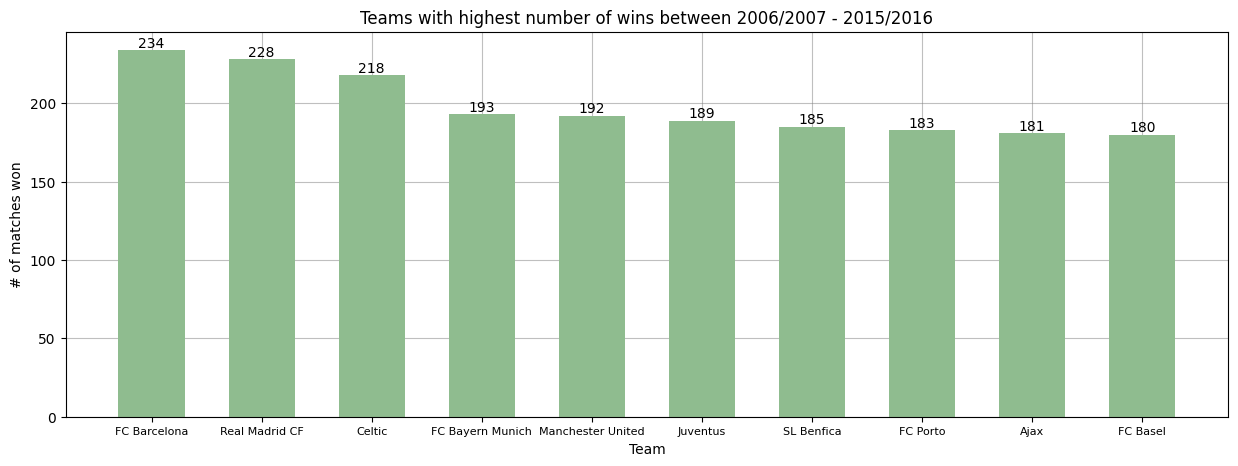

In [153]:
plt.subplots(figsize=(15, 5))
locs = np.arange(10)
labels = list(whole_period_winner.team_long_name.iloc[:10])
mags = whole_period_winner["count"].iloc[:10]
fig = plt.bar(locs, mags, width=0.6, color="darkseagreen")
plt.xticks(locs, labels, fontsize=8)
plt.title("Teams with highest number of wins between 2006/2007 - 2015/2016")
plt.xlabel("Team", fontsize=10)
plt.ylabel("# of matches won", fontsize=10)
for i in range(len(locs)):
    plt.text(i, mags[i], mags[i], ha="center", va="bottom")
plt.grid(alpha=0.5, color="gray")
plt.rc('axes', axisbelow=True)
plt.show();

As you see in the plot above Barcelonahas the highest number of won matches with 234 match.

### 3- Is there Correlation between winning and:
* defence line class.
* chance creation from crossing class.
* defence aggression class.
* buildup play positioning class.


Here I'll prepare a dataframe to study the correlation between winning and team attributes.

In [154]:
comb_teams = pd.merge(whole_period_winner, df_teams, left_on="winner", right_on="team_api_id", how="left")
comb_teams.drop_duplicates(subset = "team_long_name_x", inplace=True)
comb_teams.drop(columns =["team_short_name", "id", "team_api_id", "team_long_name_y", "date"], inplace=True)
comb_teams.rename(columns ={"team_long_name_x" : "team_long_name"}, inplace=True)
comb_teams.dropna(inplace=True)
comb_teams.head(10)


winner  count     team_long_name buildupplayspeedclass  \
0     8634    234       FC Barcelona              Balanced   
6     8633    228     Real Madrid CF              Balanced   
12    9925    218             Celtic                  Fast   
18    9823    193   FC Bayern Munich              Balanced   
24   10260    192  Manchester United                  Fast   
30    9885    189           Juventus              Balanced   
36    9772    185         SL Benfica                  Slow   
42    9773    183           FC Porto                  Slow   
48    8593    181               Ajax                  Slow   
54    9931    180           FC Basel              Balanced   

   buildupplaydribblingclass buildupplaypassingclass  \
0                     Little                   Short   
6                     Little                   Short   
12                    Little                    Long   
18                    Little                   Mixed   
24                    Little                   Mixed   
30                    Little                   Mixed   
36                    Little                   Short   
42                    Little                   Short   
48                    Little                   Short   
54                    Little                   Mixed   

   buildupplaypositioningclass chancecreationpassingclass  \
0                    Free Form                     Normal   
6                    Free Form                      Risky   
12                   Organised                     Normal   
18                   Free Form                     Normal   
24                   Organised                     Normal   
30                   Free Form                     Normal   
36                   Free Form                     Normal   
42                   Free Form                     Normal   
48                   Free Form                     Normal   
54                   Organised                     Normal   

   chancecreationcrossingclass chancecreationshootingclass  \
0                       Normal                        Lots   
6                       Normal                        Lots   
12                        Lots                        Lots   
18                        Lots                        Lots   
24                        Lots                      Normal   
30                      Normal                        Lots   
36                      Normal                      Normal   
42                      Normal                      Normal   
48                      Normal                        Lots   
54                      Normal                      Normal   

   chancecreationpositioningclass defencepressureclass defenceaggressionclass  \
0                       Free Form                 High                Contain   
6                       Free Form               Medium                  Press   
12                      Organised               Medium                 Double   
18                      Free Form                 High                  Press   
24                      Free Form               Medium                  Press   
30                      Free Form               Medium                  Press   
36                      Free Form                 Deep                Contain   
42                      Free Form                 Deep                Contain   
48                      Organised                 Deep                Contain   
54                      Organised               Medium                  Press   

   defenceteamwidthclass defencedefenderlineclass  
0                   Wide             Offside Trap  
6                 Normal             Offside Trap  
12                  Wide                    Cover  
18                Normal                    Cover  
24                Normal                    Cover  
30                  Wide             Offside Trap  
36                Narrow             Offside Trap  
42                Narrow             Offs

In [155]:

med = comb_teams["count"].median()
above_median_winners = comb_teams.query("count >= {}".format(med))
below_median_winners = comb_teams.query("count < {}".format(med))
 

Now I'll define a function to help me explore any column against winning rate 

In [156]:
def plot_winners(column_of_comparison):
    ''' Function : plotting the percentage difference in specific column for
        above/below winning median.

        Input : the name of the column to be used as aspect of this comparison
    '''
    plt.subplots(figsize=(10, 5))
    locs = np.arange(len(above_median_winners[column_of_comparison].value_counts()))
    labels = above_median_winners[column_of_comparison].unique()
    mags1 = above_median_winners[column_of_comparison].value_counts()/above_median_winners.shape[0]
    mags2 = below_median_winners[column_of_comparison].value_counts()/below_median_winners.shape[0]
    plt.bar(locs-0.15, mags1, width=0.3, label ='Above winning median', color="C9")
    plt.bar(locs+0.15, mags2, width=0.3, label ='Below winning median', color="coral")
    plt.xticks(locs, labels)
    plt.title("Comparison between teams above/below winning median using {}".format(column_of_comparison))
    plt.xlabel("{}".format(column_of_comparison), fontsize=10)
    plt.ylabel("Percenrage", fontsize=10)
    plt.grid(alpha=0.4)
    plt.rc('axes', axisbelow=True)
    plt.legend()
    plt.show();
    print(column_of_comparison)

Lets's start with defence line class

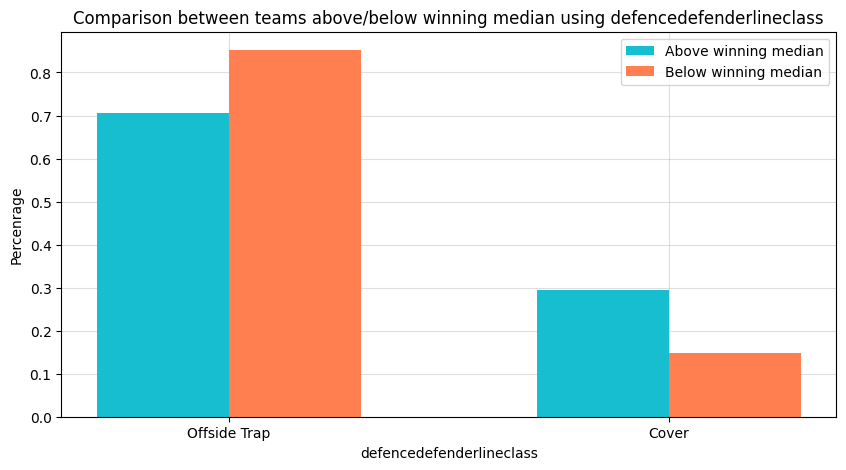

defencedefenderlineclass


In [157]:
plot_winners("defencedefenderlineclass")

The percentage of teams using offside trap is higher in winning teams.

Now we will explore chance creation crossing class column

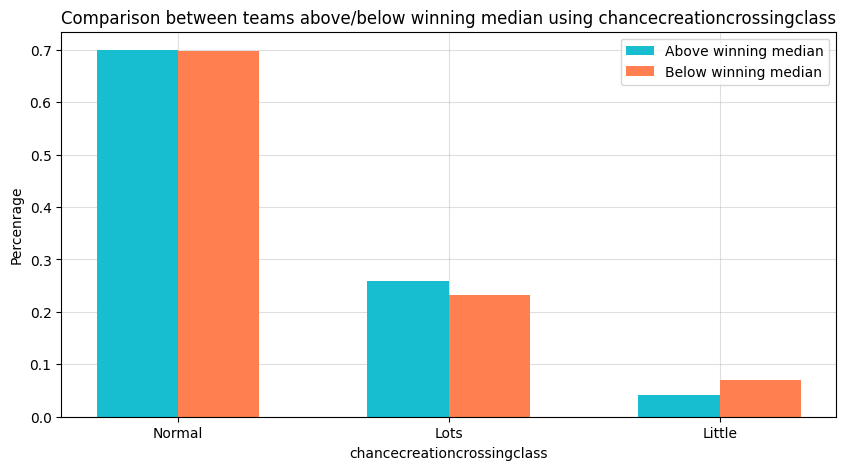

chancecreationcrossingclass


In [158]:
plot_winners("chancecreationcrossingclass")

There is no significant variety between teams above/below median

Here we study defence aggression classes for teams above/below winning median

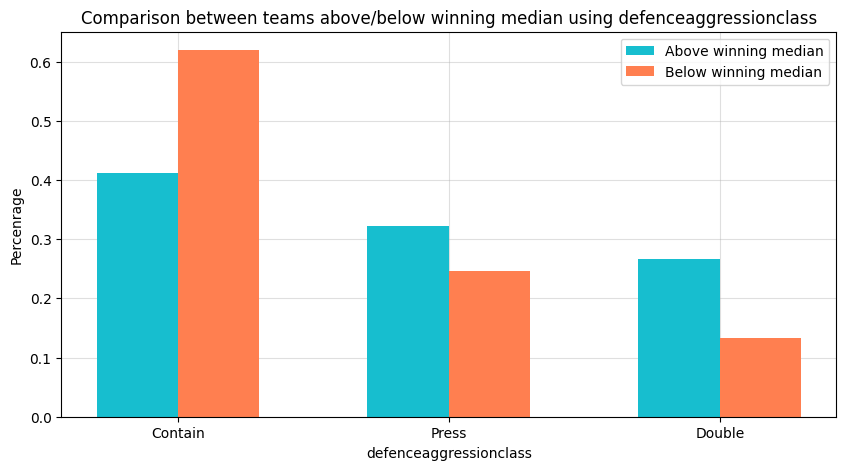

defenceaggressionclass


In [159]:
plot_winners("defenceaggressionclass")

notice that teams bellow winning median has a higher percentage of using high press as a defence strategy, But teams above winning median has higher percentage in using contained defence and using both contained and high press defence.

Here we study the buildup play positioning classes for teams above/below winning median.

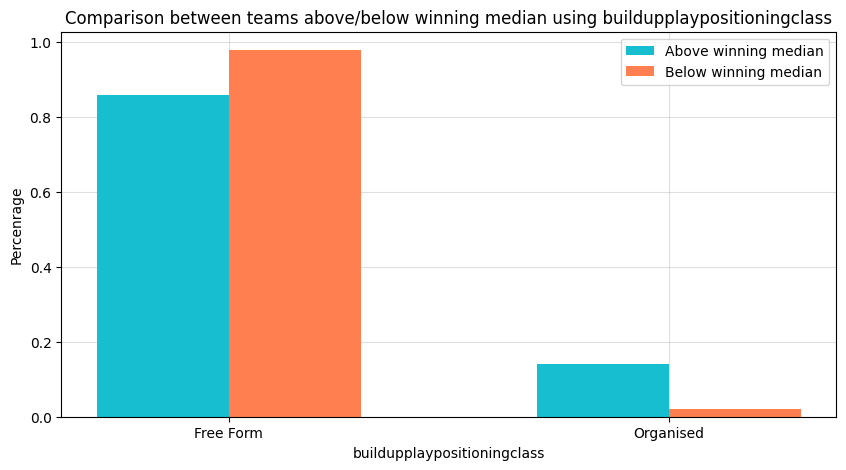

buildupplaypositioningclass


In [160]:
plot_winners("buildupplaypositioningclass")


The percentage of teams above winning median using free form build up play is higher than in teams below winning median. 

### 4-Which players **gained**, **lost** the highest number of rating points between 2007-2016?

In [161]:
df_players.head()

player_api_id         player_name   birthday  height  weight       date  \
0         505942  Aaron Appindangoye 1992-02-29  182.88     187 2016-02-18   
1         505942  Aaron Appindangoye 1992-02-29  182.88     187 2015-11-19   
2         505942  Aaron Appindangoye 1992-02-29  182.88     187 2015-09-21   
3         505942  Aaron Appindangoye 1992-02-29  182.88     187 2015-03-20   
4         505942  Aaron Appindangoye 1992-02-29  182.88     187 2007-02-22   

   overall_rating  heading_accuracy  volleys  dribbling  ...  agility  \
0            67.0              71.0     44.0       51.0  ...     59.0   
1            67.0              71.0     44.0       51.0  ...     59.0   
2            62.0              71.0     44.0       51.0  ...     59.0   
3            61.0              70.0     43.0       50.0  ...     59.0   
4            61.0              70.0     43.0       50.0  ...     59.0   

   reactions  balance  shot_power  jumping  stamina  strength  long_shots  \
0       47.0     65.0        55.0     58.0     54.0      76.0        35.0   
1       47.0     65.0        55.0     58.0     54.0      76.0        35.0   
2       47.0     65.0        55.0     58.0     54.0      76.0        35.0   
3       46.0     65.0        54.0     58.0     54.0      76.0        34.0   
4       46.0     65.0        54.0     58.0     54.0      76.0        34.0   

   aggression  year  
0        71.0  2016  
1        71.0  2015  
2        63.0  2015  
3        62.0  2015  
4        62.0  2007  

[5 rows x 22 columns]

creating a dataframe containing the overall ratings for players in 2016.

In [162]:
players_2016 = df_players.query("year == 2016")
players_2016.drop_duplicates(subset= "player_name", inplace=True)
players_2016.shape
players_2016.rename(columns = lambda x : str(x)+"_2016", inplace= True) 
players_2016.head()


player_api_id_2016    player_name_2016 birthday_2016  height_2016  \
0                505942  Aaron Appindangoye    1992-02-29       182.88   
5                155782     Aaron Cresswell    1989-12-15       170.18   
38               162549         Aaron Doran    1991-05-13       170.18   
64                30572       Aaron Galindo    1982-05-08       182.88   
112               27316          Aaron Hunt    1986-09-04       182.88   

     weight_2016  date_2016  overall_rating_2016  heading_accuracy_2016  \
0            187 2016-02-18                 67.0                   71.0   
5            146 2016-04-21                 74.0                   58.0   
38           163 2016-01-07                 65.0                   60.0   
64           198 2016-04-21                 69.0                   68.0   
112          161 2016-04-28                 77.0                   64.0   

     volleys_2016  dribbling_2016  ...  agility_2016  reactions_2016  \
0            44.0            51.0  ...          59.0            47.0   
5            40.0            73.0  ...          78.0            67.0   
38           52.0            66.0  ...          85.0            51.0   
64           48.0            56.0  ...          62.0            57.0   
112          77.0            78.0  ...          76.0            80.0   

     balance_2016  shot_power_2016  jumping_2016  stamina_2016  strength_2016  \
0            65.0             55.0          58.0          54.0           76.0   
5            90.0             71.0          85.0          79.0           56.0   
38           92.0             61.0          65.0          66.0           71.0   
64           41.0             59.0          71.0          49.0           90.0   
112          72.0             76.0          65.0          75.0           65.0   

     long_shots_2016  aggression_2016  year_2016  
0               35.0             71.0       2016  
5               62.0             68.0       2016  
38              57.0             60.0       2016  
64              29.0             70.0       2016  
112             76.0             59.0       2016  

[5 rows x 22 columns]

creating a dataframe containing the overall ratings for players in 2007.

In [163]:
players_2007 = df_players.query("year == 2007")
players_2007.drop_duplicates(subset= "player_name", inplace=True)
players_2007.shape
players_2007.rename(columns = lambda x : str(x)+"_2007", inplace= True) 
players_2007.head()

player_api_id_2007    player_name_2007 birthday_2007  height_2007  \
4                505942  Aaron Appindangoye    1992-02-29       182.88   
37               155782     Aaron Cresswell    1989-12-15       170.18   
63               162549         Aaron Doran    1991-05-13       170.18   
85                30572       Aaron Galindo    1982-05-08       182.88   
110               23780        Aaron Hughes    1979-11-08       182.88   

     weight_2007  date_2007  overall_rating_2007  heading_accuracy_2007  \
4            187 2007-02-22                 61.0                   70.0   
37           146 2007-02-22                 53.0                   52.0   
63           163 2007-02-22                 59.0                   45.0   
85           198 2007-08-30                 71.0                   70.0   
110          154 2007-08-30                 71.0                   76.0   

     volleys_2007  dribbling_2007  ...  agility_2007  reactions_2007  \
4            43.0            50.0  ...          59.0            46.0   
37           30.0            26.0  ...          59.0            65.0   
63           63.0            65.0  ...          66.0            51.0   
85           48.0            52.0  ...          63.0            62.0   
110          32.0            63.0  ...          57.0            70.0   

     balance_2007  shot_power_2007  jumping_2007  stamina_2007  strength_2007  \
4            65.0             54.0          58.0          54.0           76.0   
37           62.0             48.0          48.0          56.0           68.0   
63           56.0             64.0          56.0          69.0           68.0   
85           45.0             65.0          69.0          75.0           68.0   
110          76.0             47.0          78.0          78.0           72.0   

     long_shots_2007  aggression_2007  year_2007  
4               34.0             62.0       2007  
37              35.0             64.0       2007  
63              63.0             59.0       2007  
85              51.0             70.0       2007  
110             20.0             76.0       2007  

[5 rows x 22 columns]

the next step is to merge the dataframes of 2007 and 2016 and to create a new column containing the difference btween 2016 rating and 2017 rating for every player .

1. for most improved players we will sort values of the column `improved` ascendingly.

2. for least improved players we will sort values of the column `improved` descendingly.

In [164]:
comb_2007_2016 = pd.merge(players_2007, players_2016, left_on="player_name_2007", right_on="player_name_2016", how="inner")
comb_2007_2016.drop(columns = ['birthday_2007',
       'height_2007', 'weight_2007', 'date_2007',
       'heading_accuracy_2007', 'volleys_2007', 'dribbling_2007',
       'acceleration_2007', 'sprint_speed_2007', 'agility_2007',
       'reactions_2007', 'balance_2007', 'shot_power_2007', 'jumping_2007',
       'stamina_2007', 'strength_2007', 'long_shots_2007', 'aggression_2007',
       'year_2007', 'player_api_id_2016', 'player_name_2016', 'birthday_2016',
       'height_2016', 'weight_2016', 'date_2016',
       'heading_accuracy_2016', 'volleys_2016', 'dribbling_2016',
       'acceleration_2016', 'sprint_speed_2016', 'agility_2016',
       'reactions_2016', 'balance_2016', 'shot_power_2016', 'jumping_2016',
       'stamina_2016', 'strength_2016', 'long_shots_2016', 'aggression_2016',
       'year_2016'], inplace=True)
comb_2007_2016["improved"] = comb_2007_2016.overall_rating_2016 - comb_2007_2016.overall_rating_2007
comb_2007_2016.sort_values("improved", inplace=True, ascending=False)
most_developed_players = comb_2007_2016.head(10)
most_developed_players.rename(columns={"player_api_id_2007": "player_api_id", "player_name_2007": "player_name"}, inplace=True)
least_developed_players = comb_2007_2016.tail(10).sort_values("improved")
least_developed_players.rename(columns={"player_api_id_2007": "player_api_id", "player_name_2007": "player_name"}, inplace=True)

In [165]:
most_developed_players

player_api_id        player_name  overall_rating_2007  \
3338         129944         Marco Reus                 44.0   
4345          41433   Radja Nainggolan                 46.0   
4470         115591  Ricardo Rodriguez                 45.0   
4111         181297    Oscar de Marcos                 43.0   
1410         107417        Eden Hazard                 51.0   
567           46417        Bakary Sako                 38.0   
2935          93457        Lamine Kone                 38.0   
3012          24235   Leonardo Bonucci                 47.0   
2020         170775    Haris Seferovic                 41.0   
5451         168342     Yannis Salibur                 39.0   

      overall_rating_2016  improved  
3338                 86.0      42.0  
4345                 83.0      37.0  
4470                 82.0      37.0  
4111                 80.0      37.0  
1410                 88.0      37.0  
567                  75.0      37.0  
2935                 74.0      36.0  
3012                 83.0      36.0  
2020                 76.0      35.0  
5451                 74.0      35.0

In [166]:
least_developed_players

player_api_id            player_name  overall_rating_2007  \
1274          39660          Derek Riordan                 79.0   
4992          41060        Stephen McManus                 85.0   
3857          23916  Morten Gamst Pedersen                 85.0   
2898          32867              Kris Boyd                 86.0   
1793          30739             Gael Givet                 82.0   
1818          36802        Gary McSheffrey                 76.0   
576           32455           Barry Robson                 80.0   
856           34421         Chris Kirkland                 77.0   
3019          23286             Leroy Lita                 80.0   
3964          23282           Nicky Shorey                 77.0   

      overall_rating_2016  improved  
1274                 59.0     -20.0  
4992                 66.0     -19.0  
3857                 68.0     -17.0  
2898                 69.0     -17.0  
1793                 65.0     -17.0  
1818                 60.0     -16.0  
576                  64.0     -16.0  
856                  61.0     -16.0  
3019                 64.0     -16.0  
3964                 61.0     -16.0

C:\Users\HP\AppData\Local\Temp\ipykernel_6580\1691967292.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(most_developed_players.player_name, rotation=30, ha='right', rotation_mode='anchor', fontsize=12)
C:\Users\HP\AppData\Local\Temp\ipykernel_6580\1691967292.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(least_developed_players.player_name, rotation=30, ha="left", rotation_mode='anchor', fontsize=12)


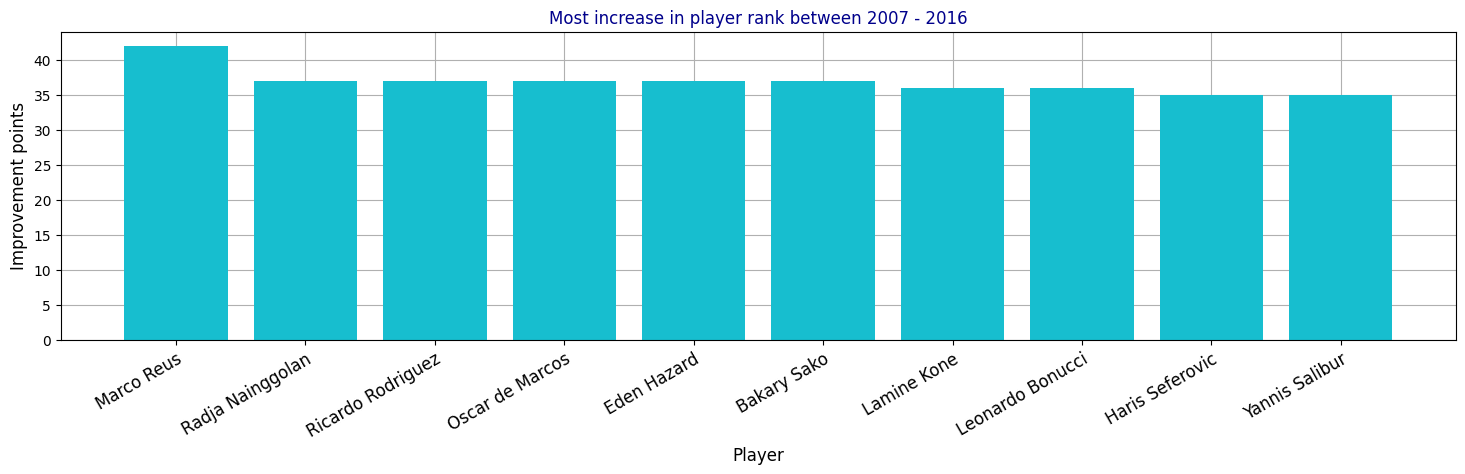

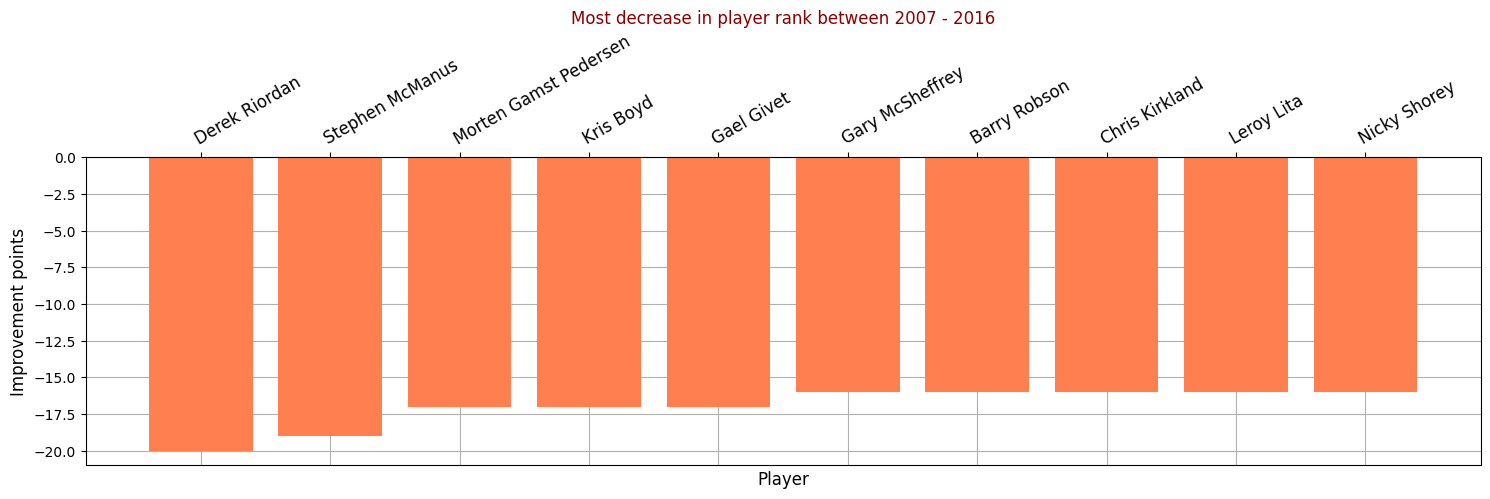

In [167]:
fig1, ax1=plt.subplots(nrows=1, ncols=1, figsize=(18, 4))

ax1.bar(most_developed_players.player_name, most_developed_players.improved, width=0.8, color="C9")
ax1.set_title("Most increase in player rank between 2007 - 2016", color="darkblue")
ax1.set_xlabel("Player", fontsize=12)
ax1.set_ylabel("Improvement points", fontsize=12)
ax1.set_xticklabels(most_developed_players.player_name, rotation=30, ha='right', rotation_mode='anchor', fontsize=12)
ax1.set_axisbelow(True)
ax1.grid();

fig2, ax2=plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
ax2.bar(least_developed_players.player_name, least_developed_players.improved, width=0.8, color="coral")
ax2.set_title("Most decrease in player rank between 2007 - 2016", color="darkred")
ax2.set_xlabel("Player", fontsize=12)
ax2.set_ylabel("Improvement points", fontsize=12)
ax2.set_xticklabels(least_developed_players.player_name, rotation=30, ha="left", rotation_mode='anchor', fontsize=12)
ax2.xaxis.set_ticks_position("top")
ax2.set_axisbelow(True)
ax2.grid();

#### The previous plots shows that:
1. Marco Reus is the most improved player from 2007 to 2016, he gained 42 ranking points.
2. Derek Riordan is the least improved player from 2007 to 2016 he lost 20 ranking points.

In [168]:
players_2016.columns

Index(['player_api_id_2016', 'player_name_2016', 'birthday_2016',
       'height_2016', 'weight_2016', 'date_2016', 'overall_rating_2016',
       'heading_accuracy_2016', 'volleys_2016', 'dribbling_2016',
       'acceleration_2016', 'sprint_speed_2016', 'agility_2016',
       'reactions_2016', 'balance_2016', 'shot_power_2016', 'jumping_2016',
       'stamina_2016', 'strength_2016', 'long_shots_2016', 'aggression_2016',
       'year_2016'],
      dtype='object')

### 5- Does *heading accuracy* rating depend on:
* height rating.
* jumping rating.
* volleys rating.
* balance rating.


In the next cell I'll create a Function that plots the relationship between the chosen columns.

In [169]:
def player_atts_correlation(dep_var, ind_var1, ind_var2, ind_var3, ind_var4):
    ''' Function : creates a dataframe for the chosen columns and
        plots the relation between these columns

        Input : columns' names to be studied.
    '''
    df = players_2016[[dep_var, ind_var1, ind_var2, ind_var3, ind_var4]]
    df.rename(columns= lambda x : str(x)[:-5], inplace=True)
    pd.plotting.scatter_matrix(df, figsize=(12, 12));

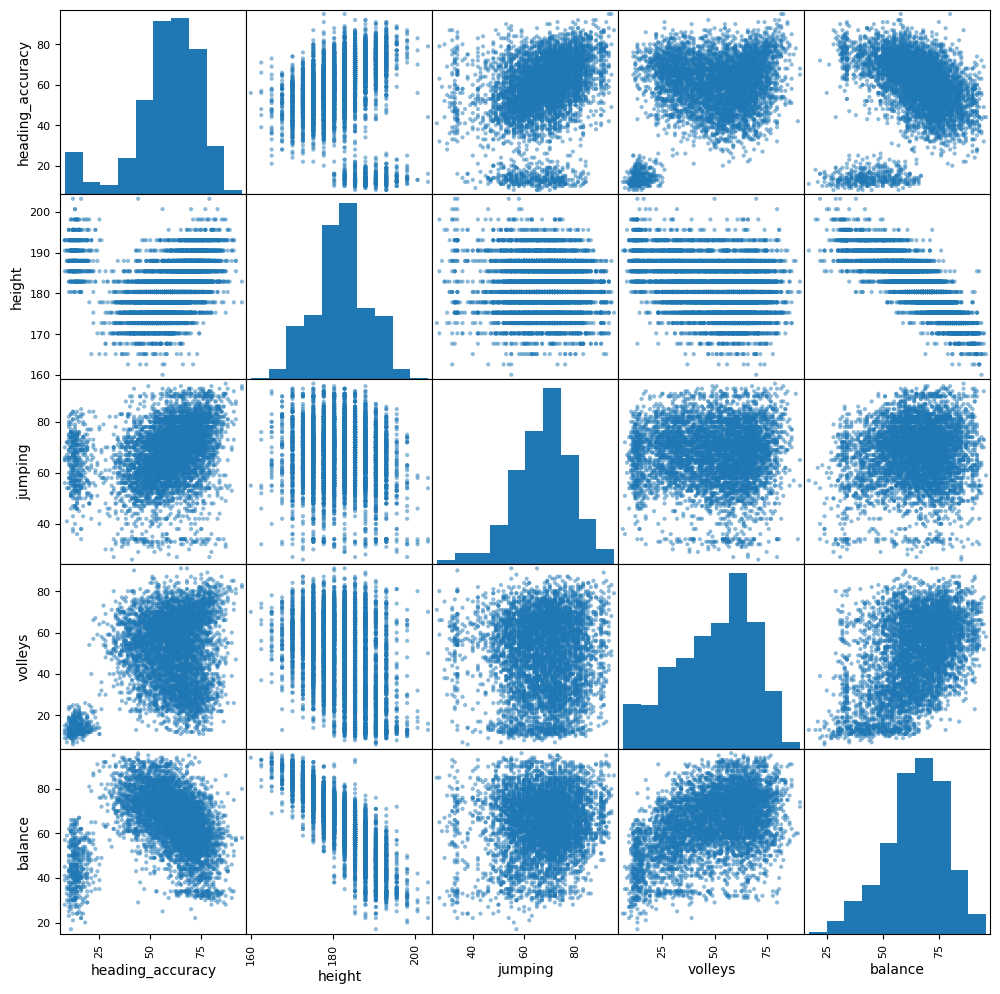

In [170]:
player_atts_correlation('heading_accuracy_2016', 'height_2016',  'jumping_2016', 'volleys_2016', 'balance_2016')

As we see there is no obvious correlation between heading accuracy and other variables, But we also notice that there is strong **negative correlation** between height and balance.

### 6- Does *longshots* rating depend on:
* aggression rating.
* weight rating.
* shot power rating.
* strength rating.

1. In the next cell I'll create a dataframe including the meant columns and remove year from column name.
2. Then create a scatter matrix to plot the relationship between columns. 

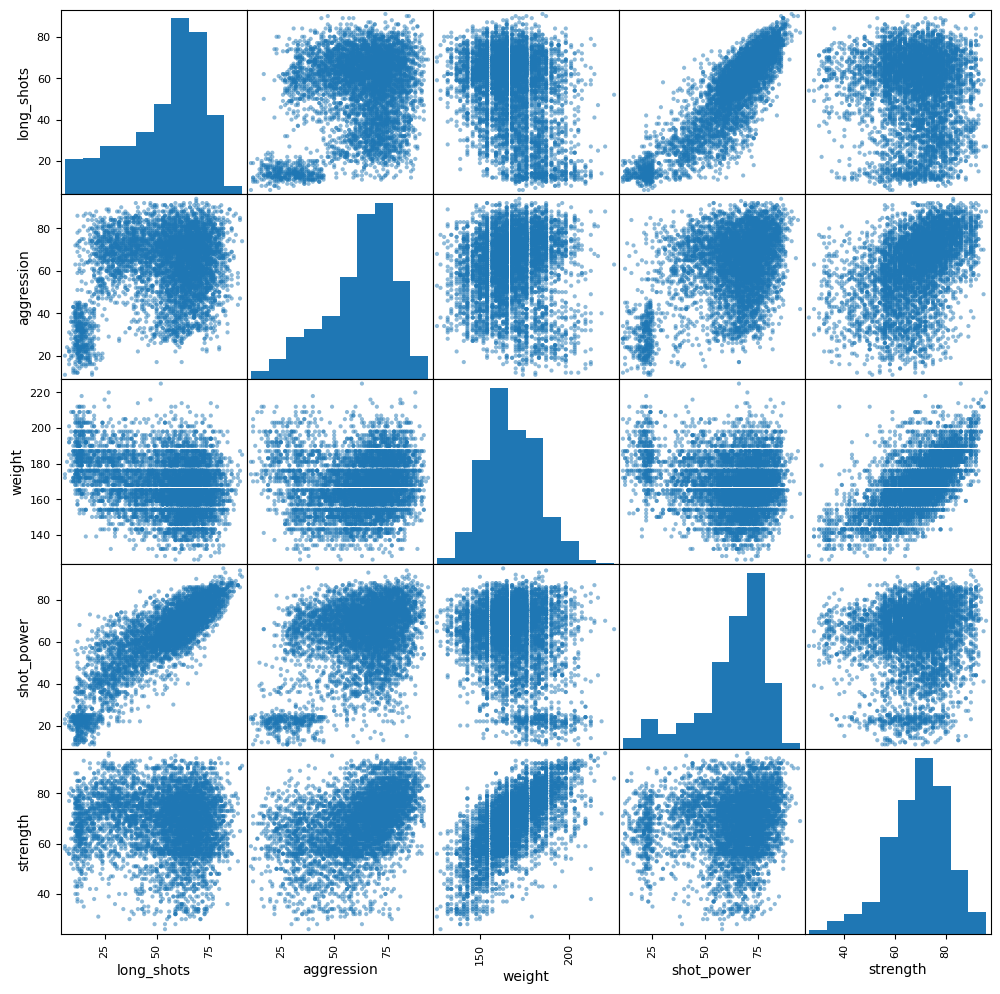

In [171]:
player_atts_correlation('long_shots_2016', 'aggression_2016',  'weight_2016', 'shot_power_2016', 'strength_2016')

As we see there is a strong correlation between long shots and shot power, and there is a considerable correlation between strenght and weight.

### 7- Does *dribbling* rating depend on:
* agility rating.
* acceleration rating.
* reactions rating.
* balance rating.

1. In the next cell I'll create a dataframe including the meant columns and remove year from column name.
2. Then create a scatter matrix to plot the relationship between columns. 

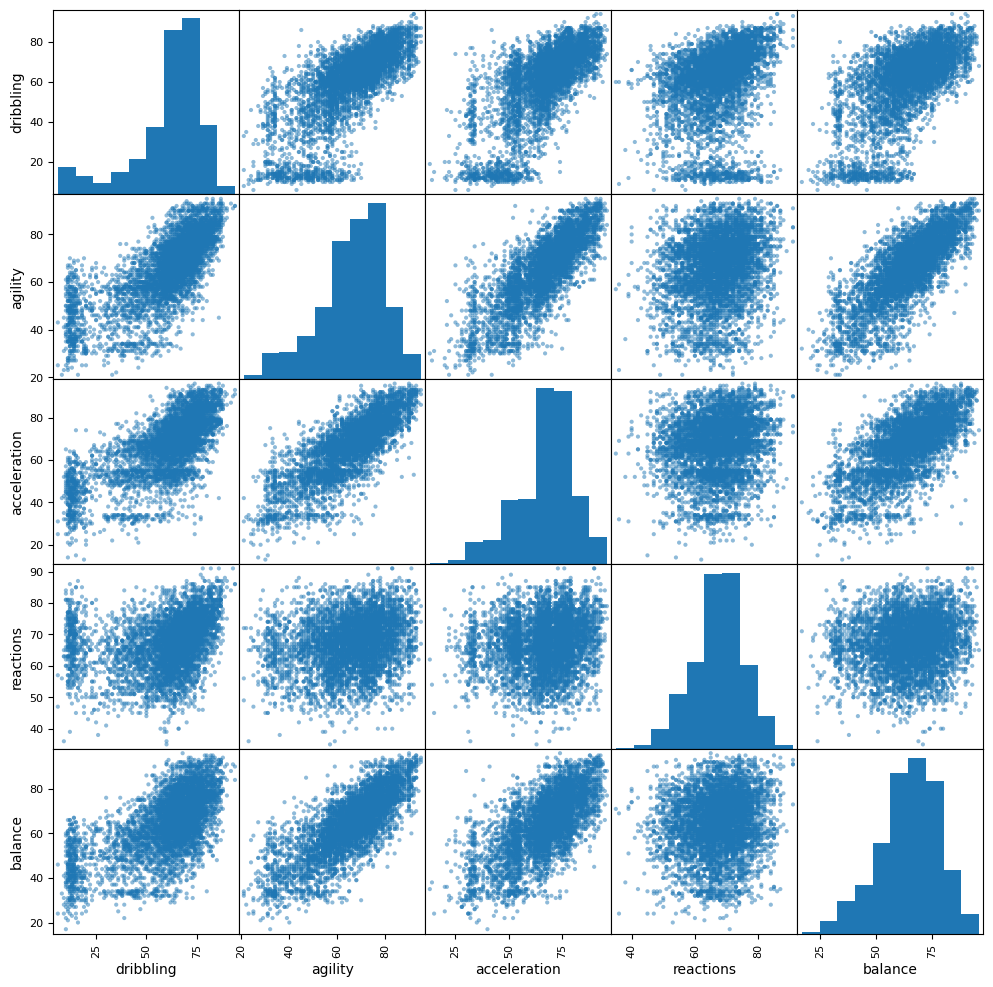

In [172]:
player_atts_correlation('dribbling_2016', 'agility_2016',  'acceleration_2016', 'reactions_2016', 'balance_2016')

Above we see that there is moderate correlation between dribbling rating and both agility and acceleration ratings.

### 8- Does *sprint speed* rating depend on:
* acceleration rating.
* stamina rating.
* height rating.
* weight rating.

1. In the next cell I'll create a dataframe including the meant columns and remove year from column name.
2. Then create a scatter matrix to plot the relationship between columns. 

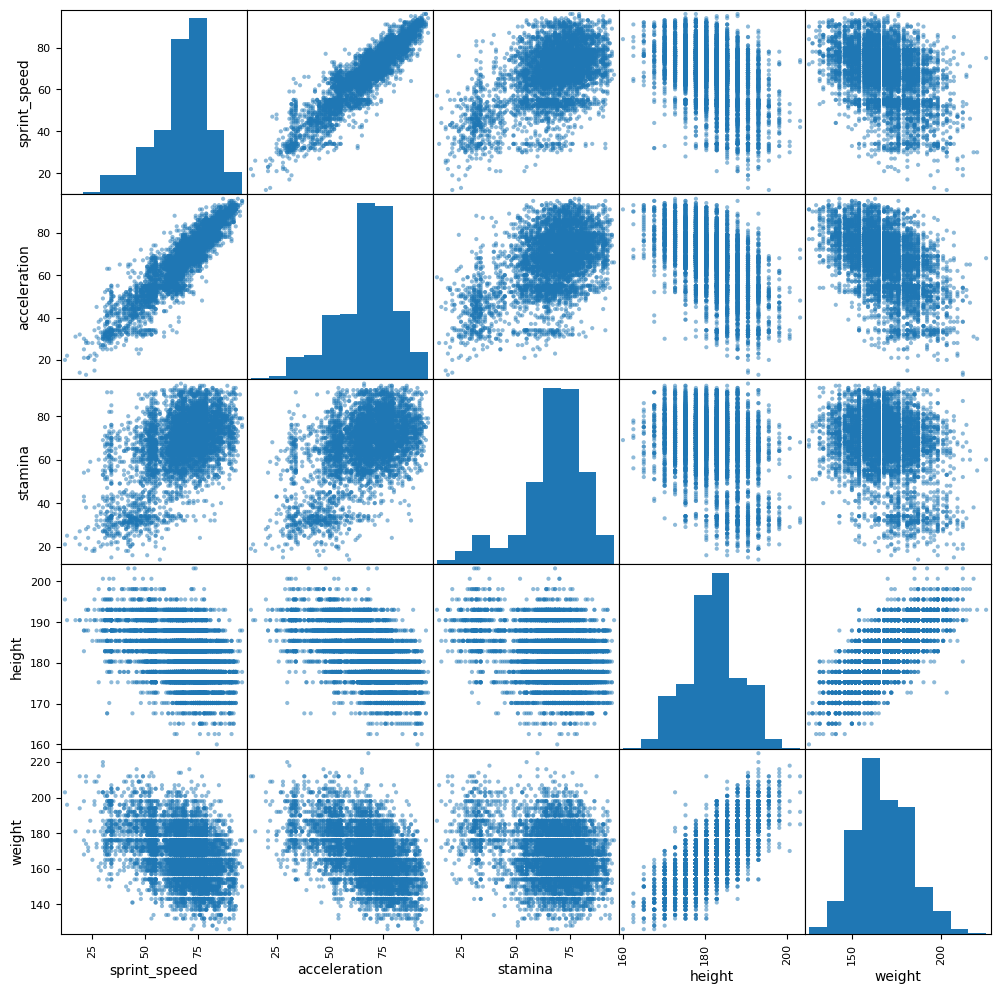

In [173]:
player_atts_correlation('sprint_speed_2016', 'acceleration_2016',  'stamina_2016', 'height_2016', 'weight_2016')

The above matrix shows strong correlation between sprint speed and acceleration, And a moderate **negative correlation** between sprint speed and weight.

### 9- Comparison between Lionel Messi and Cristiano ronaldo overall rating trend between 2007-2015.


Create two dataframes for messi and ronaldo by searching their names in *players* dataframe as substring. And from dataframes drop every column other than year and overall rating.

In [174]:
substring = 'messi'
df_messi = df_players[df_players.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
df_messi.drop(columns=['player_api_id', 'birthday', 'height', 'weight', 'heading_accuracy', 'volleys', 'dribbling',
       'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
       'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression'], inplace=True)


In [175]:
substring = 'cristiano ronaldo'
df_ronaldo = df_players[df_players.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
df_ronaldo.drop(columns=['player_api_id', 'birthday', 'height', 'weight', 'heading_accuracy', 'volleys', 'dribbling',
       'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
       'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression'], inplace=True)


for each dataframe we will use `.groupby` to group rows by years then use `.first` method to keep only the last overall update for each year.

In [176]:
groups = df_messi.groupby('year', as_index=False)
messi = groups.first()


In [177]:
groups2 = df_ronaldo.groupby('year', as_index=False)
ronaldo = groups2.first()

C:\Users\HP\AppData\Local\Temp\ipykernel_6580\3414535049.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=["2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015"])


[Text(-1.0, 0, '2006'),
 Text(0.0, 0, '2007'),
 Text(1.0, 0, '2008'),
 Text(2.0, 0, '2009'),
 Text(3.0, 0, '2010'),
 Text(4.0, 0, '2011'),
 Text(5.0, 0, '2012'),
 Text(6.0, 0, '2013'),
 Text(7.0, 0, '2014'),
 Text(8.0, 0, '2015'),
 Text(9.0, 0, '')]

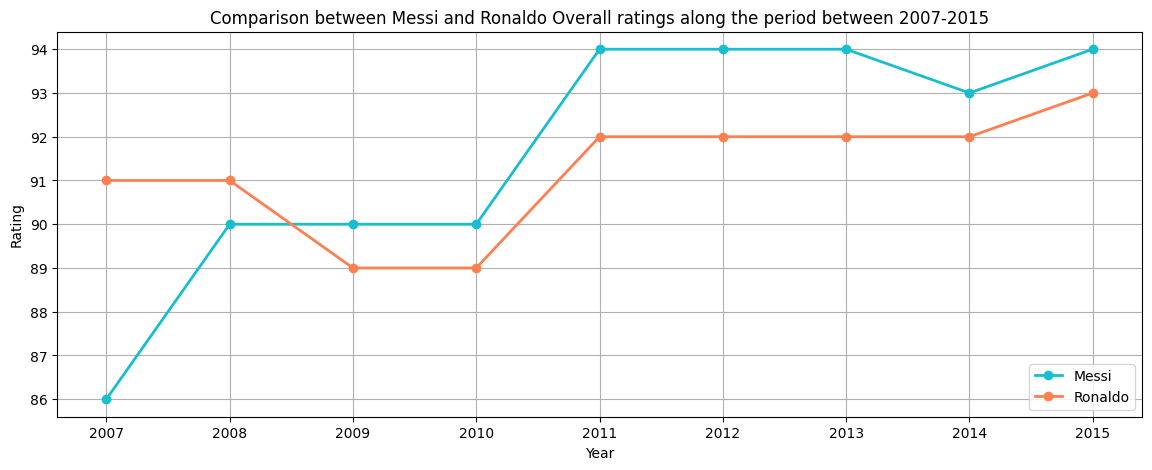

In [178]:
fig, ax = plt.subplots(figsize=(14,5))
locs = np.arange(len(messi.year))
vals_m = messi.overall_rating
vals_c = ronaldo.overall_rating
labels = ronaldo["year"]
ax.plot(locs, vals_m, color="C9", marker="o", linewidth=2)
ax.plot(locs, vals_c, color="coral", marker="o", linewidth=2)
ax.grid()
ax.set_title("Comparison between Messi and Ronaldo Overall ratings along the period between 2007-2015")
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Rating", fontsize=10)
ax.legend(labels= ["Messi", "Ronaldo"], loc="lower right")
ax.set_xticklabels(labels=["2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015"])




here we notice that Messi has higher ratings than Ronaldo in all years exept 2007, 2008

<a id='conclusion'></a>
## Conclusions

1. Real madrid had the highest number of wins in Europe for 3 seasons between 2007-2016.
2. Winning teams has higher percentage in using offside trap.
3. Winning teams has higher percentage in using contain and double defence rather than high press.
4. Winning teams has higher percentage in using free form during buildup phase.
5. Marco Reus gained the highest numer of overall rank points between 2007-2016.
6. Derek Riordan lost the highest numer of overll rank points between 2007-2016.
7. Variables with positive correlation:
    * (long shots / shot power) strong 
    * (sprint speed / acceleration) strong
    * (dribbling / aglity, acceleration) moderate
8. Variables with negative correlation:
    * (height / balance) strong
    * (sprint speed / weight) moderate
9. Messi had higher overall ratings in all years exept 2007, 2008.

##### Remember that:
1. number of wins are local to the teams' national competetion.
2. mathes with draw results has been omitted.
3. players and teams attributes are scraped from **FIFA Game** and may not apply to real world.
